In [4]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
from aa_train_utils.dataset_generation import joint, uniform, f6, f5, f2, RegressionDataset , generate_noisy_split_trainingdata
from aa_train_utils.spl_curriculum import SPL_curriculum 

import jax
import jax.numpy as jnp
import jax.tree_util
from jax.scipy.stats.norm import logpdf
from jax.scipy.stats.t import ppf
import pickle

import numpy as np
import pickle
import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map


ImportError: cannot import name 'ppf' from 'jax.scipy.stats.t' (/home/aszalos-arpad/Github/CL_for_faster_Meta-learning/.venv/lib/python3.12/site-packages/jax/scipy/stats/t.py)

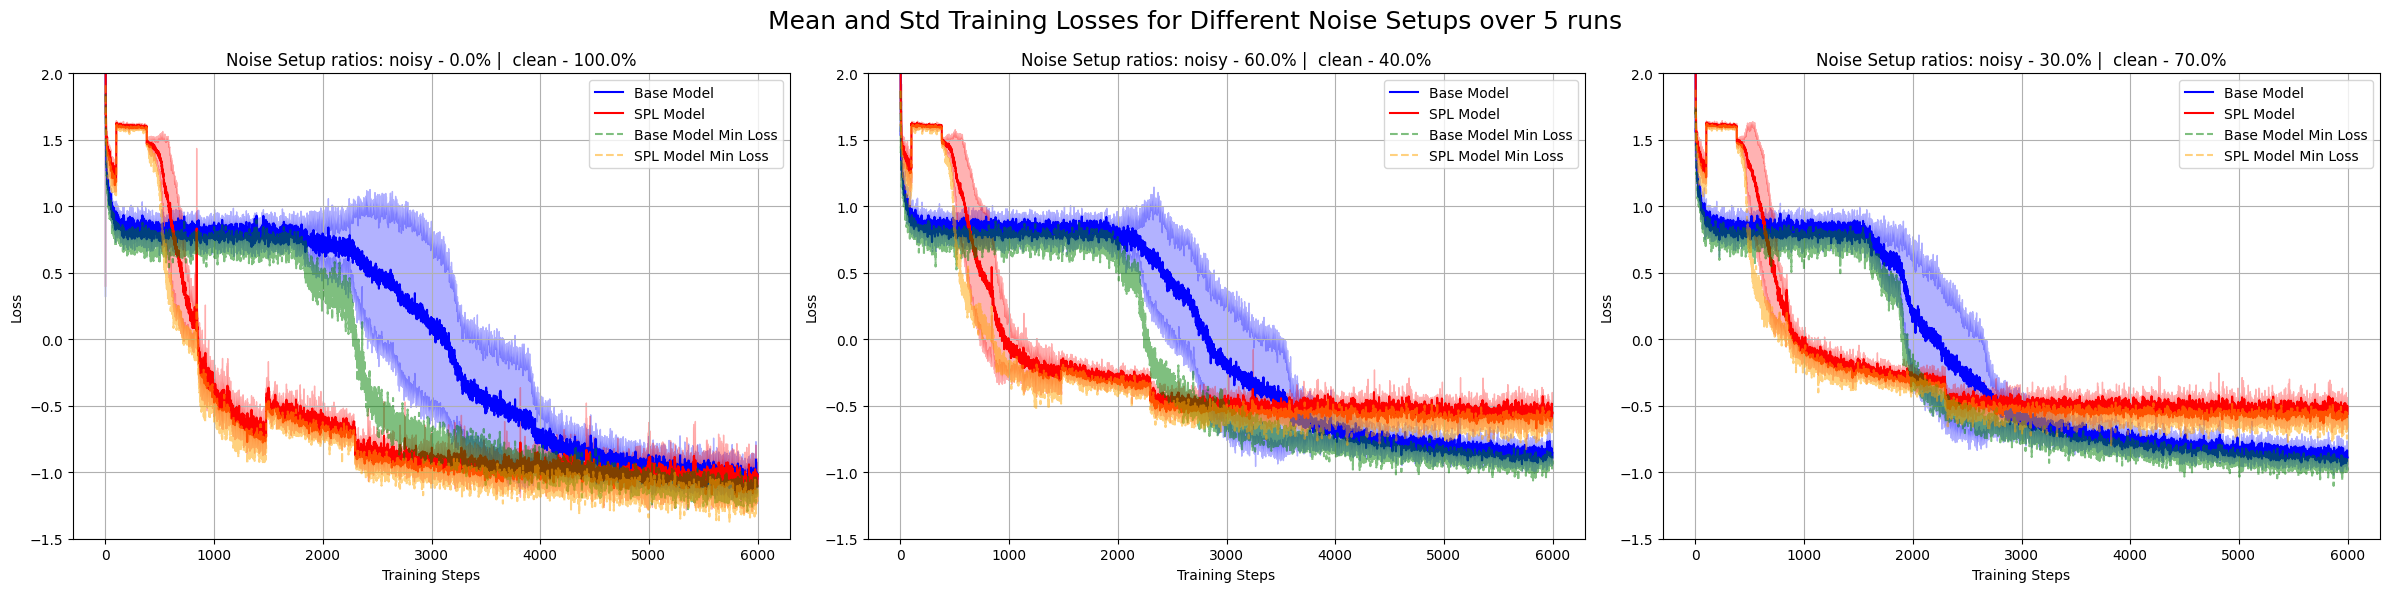

In [5]:
# Firstly we will need to load in the necessary training metrics for a single run. 

# for baseline this takes the form within a given folder (base_0_1)

# Set the experiment directory
experiment_directory = "exp_ds_5runs"

# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)


# Create a figure with subplots for each noise setup
fig, axs = plt.subplots(1, num_noise_setups, figsize=(8 * num_noise_setups, 6))

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store losses for each model
    base_losses = []
    spl_losses = []

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Iterate over each file in the noise setup directory
    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the training metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                training_metrics = pickle.load(f)
            
            # Append losses to the corresponding model's list
            if model_name == "base":
                base_losses.append(training_metrics["training_loss"])
            else:
                spl_losses.append(training_metrics["training_loss"])

    # Convert the lists to numpy arrays
    base_losses = np.array(base_losses)
    spl_losses = np.array(spl_losses)

    # Calculate the mean, minimum, and standard deviation of the losses for each model
    base_mean_loss = np.mean(base_losses, axis=0)
    base_min_loss = np.min(base_losses, axis=0)
    base_std_loss = np.std(base_losses, axis=0)

    spl_mean_loss = np.mean(spl_losses, axis=0)
    spl_min_loss = np.min(spl_losses, axis=0)
    spl_std_loss = np.std(spl_losses, axis=0)

    # Plot the mean losses for each model
    axs[i].plot(base_mean_loss, label="Base Model", color="blue")
    axs[i].fill_between(range(len(base_mean_loss)), base_mean_loss - base_std_loss, base_mean_loss + base_std_loss, color="blue", alpha=0.3)
    axs[i].plot(spl_mean_loss, label="SPL Model", color="red")
    axs[i].fill_between(range(len(spl_mean_loss)), spl_mean_loss - spl_std_loss, spl_mean_loss + spl_std_loss, color="red", alpha=0.3)
   # Plot the minimum losses for each model
    # Plot the minimum losses for each model
    axs[i].plot(base_min_loss, linestyle="--", label="Base Model Min Loss", color="green", alpha=0.5)
    axs[i].plot(spl_min_loss, linestyle="--", label="SPL Model Min Loss", color="orange", alpha=0.5)
    # Set title and labels
    axs[i].set_title(f"Noise Setup ratios: noisy - " + str(float(noise_levels[0])*100.0) + "% | " + " clean - " + str(float(noise_levels[1])*100.0) + "%")
    axs[i].set_xlabel("Training Steps")
    axs[i].set_ylabel("Loss")
    axs[i].set_ylim(-1.5, 2)
    axs[i].legend()

    # Show grid
    axs[i].grid(True)
# Set the title for the entire figure
fig.suptitle("Mean and Std Training Losses for Different Noise Setups over " + str(len(base_losses)) + " runs", fontsize=18)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Save plot
fig.savefig("training_losses.png")

[(12,), (12,), (12,), (12,)]


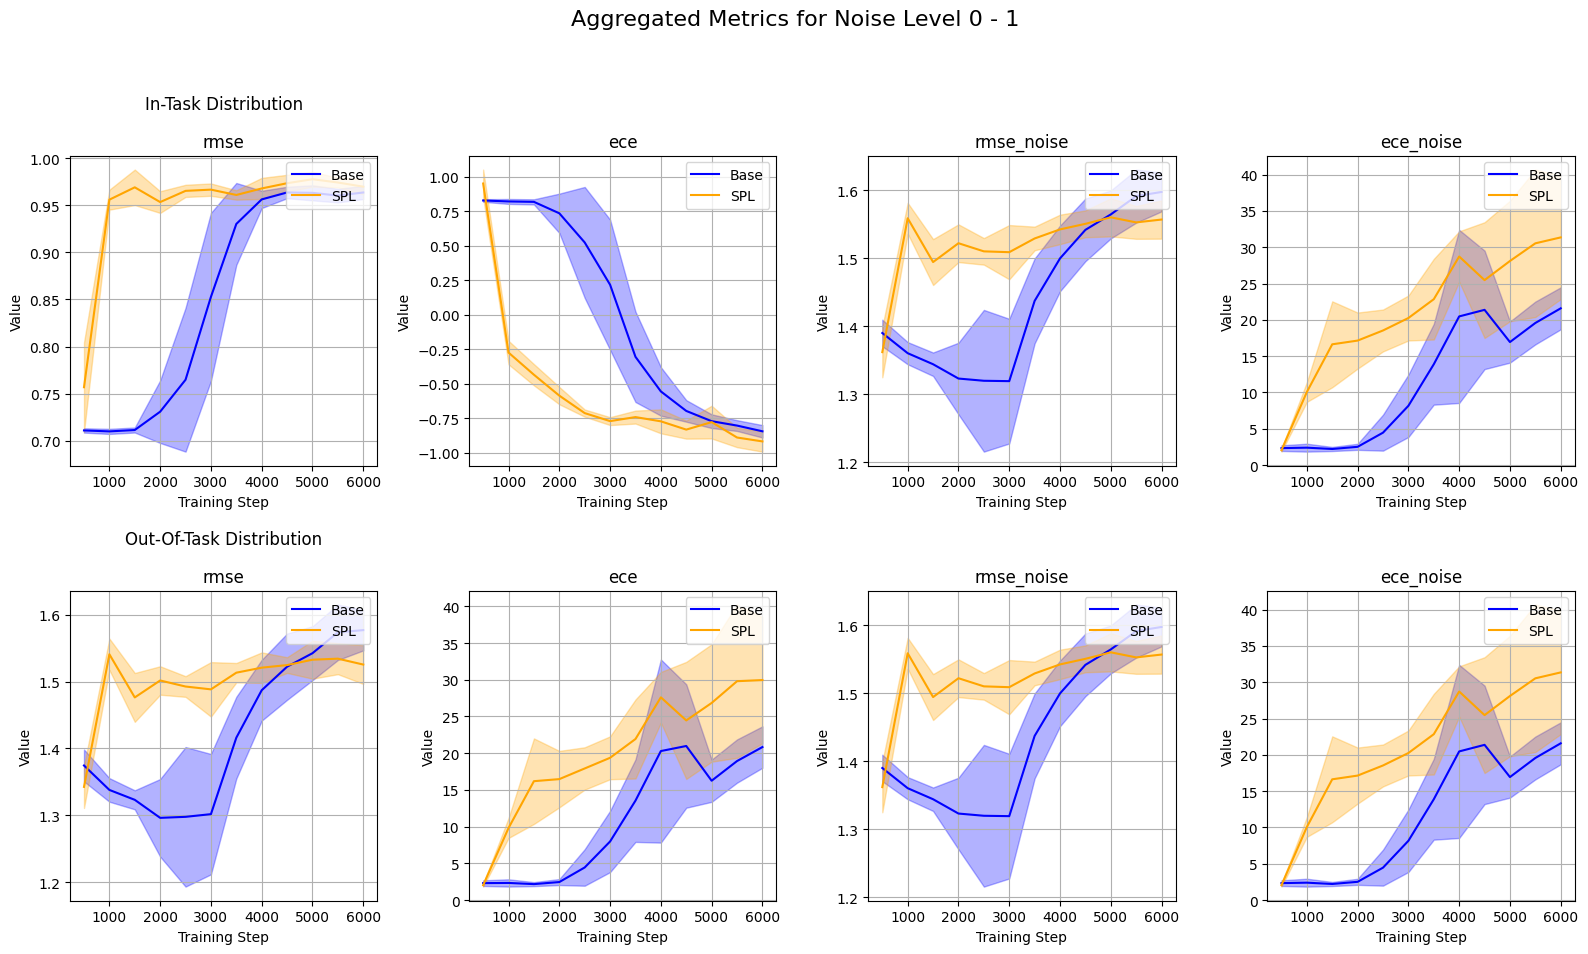

[(12,), (12,), (12,), (12,)]


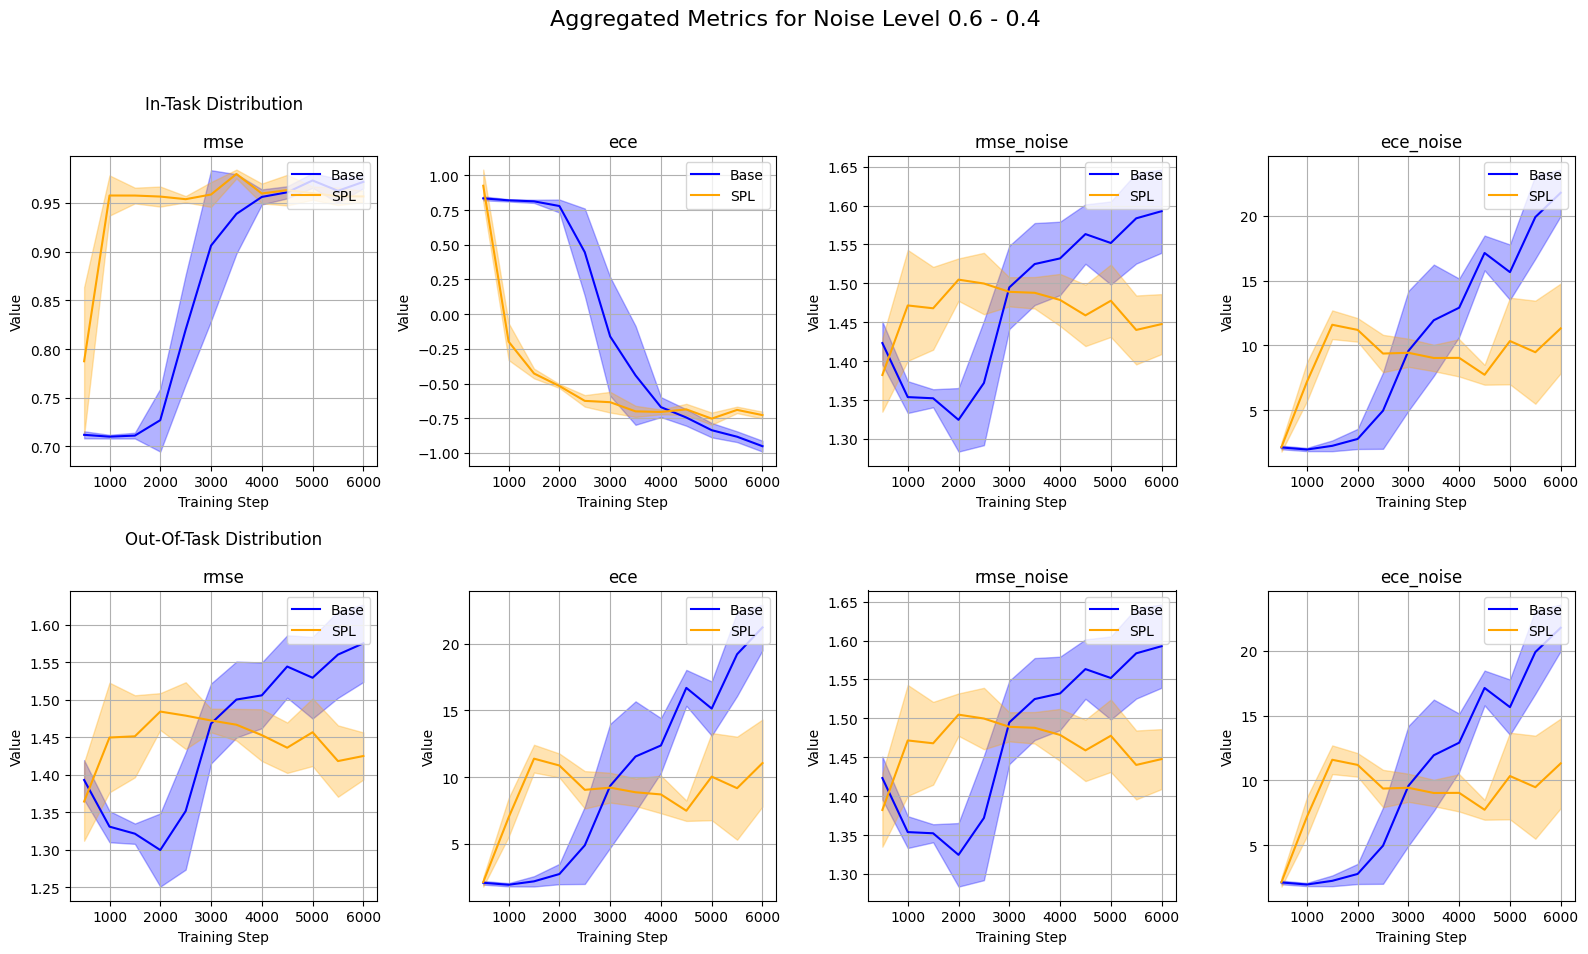

[(12,), (12,), (12,), (12,)]


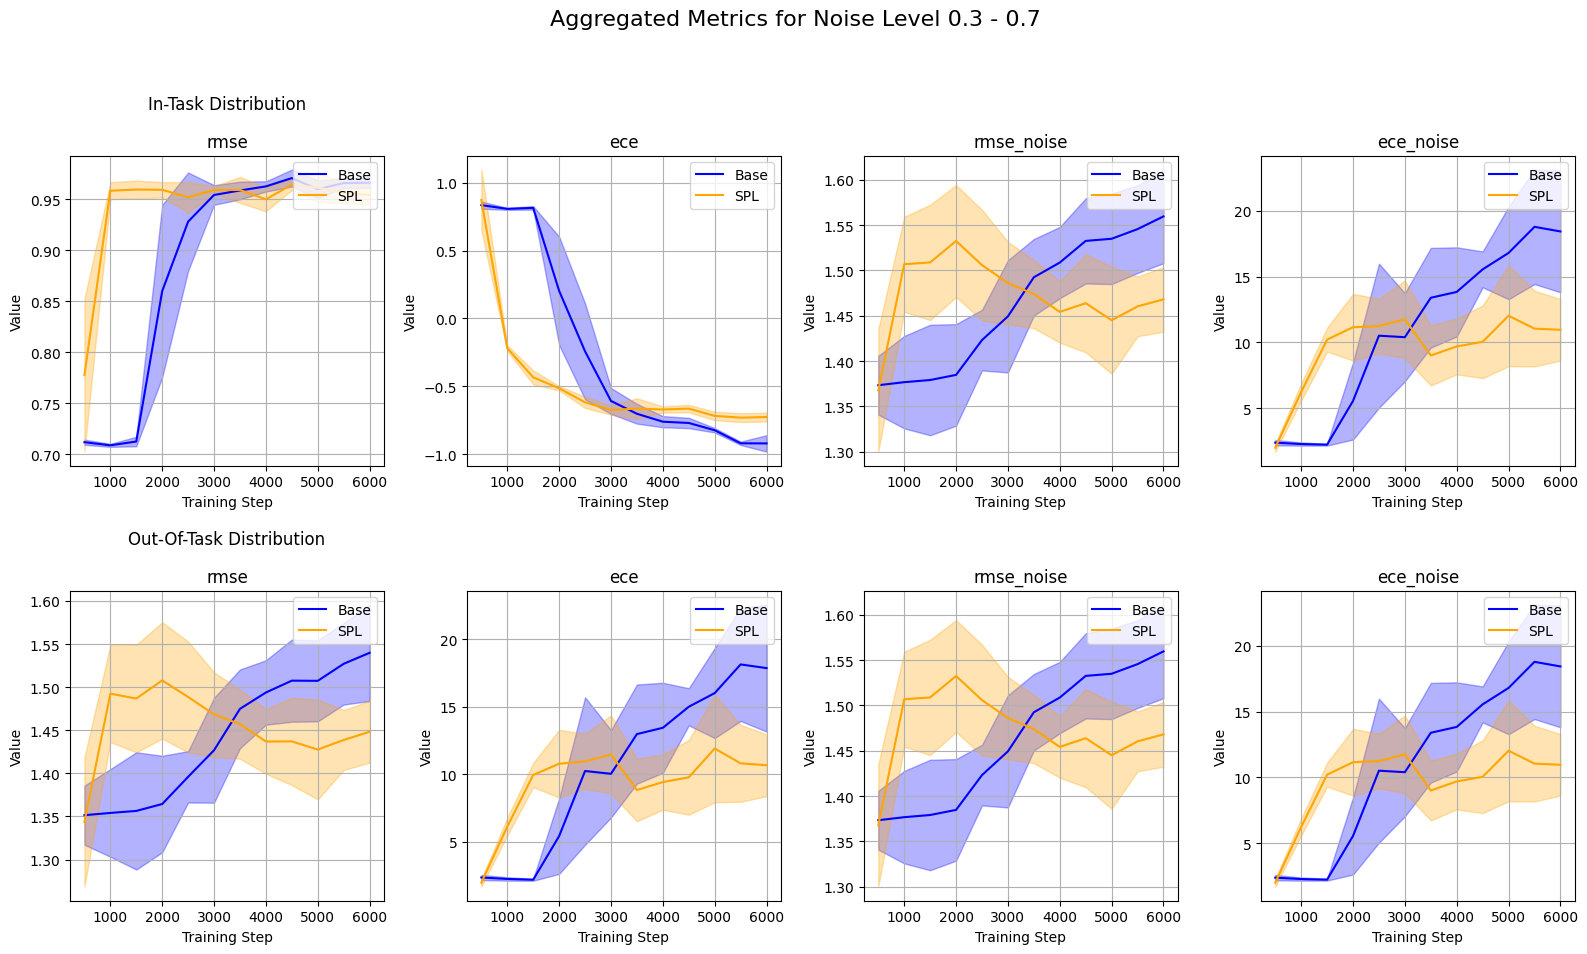

In [13]:
def comb_stds(mean, group_means, group_stds):
    # Calculate the combined standard deviation using the formula

    avg_stdscalc =sum([ (stdi**2 + (mi - mean)**2) for stdi,mi in zip(group_stds, group_means) ] )/len(group_means)

    return np.sqrt(avg_stdscalc)
# Function to separate means and stds
def separate_means_stds(metrics_dict):
    means = {}
    stds = {}
    for k, v in metrics_dict.items():
        mean_values = np.array([x[:, 0] for x in v])
        std_values = np.array([x[:, 1] for x in v])
        means[k] = mean_values
        stds[k] = std_values
    return means, stds

def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    z = ppf(1 - (1 - confidence_level) / 2)
    margin_of_error = z * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound


def plot_aggregated_metrics(ax, aggregated_base_means, aggregated_base_stds, aggregated_spl_means, aggregated_spl_stds, noise_level, task_type, metrics):
    eval_period_length = 500  # Evaluation period length in training steps

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2

        ax_curr = ax[row, col]

        # Plot base model
        x = [eval_period_length * (j + 1) for j in range(len(aggregated_base_means[metric]))]
        ax_curr.plot(x, aggregated_base_means[metric], label='Base', color='blue')

        # Plot SPL model with slight skew
        ax_curr.plot([xi + 0.1 for xi in x], aggregated_spl_means[metric], label='SPL', color='orange')

        # Plot shaded regions for standard deviations
        ax_curr.fill_between(x, aggregated_base_means[metric] - aggregated_base_stds[metric], aggregated_base_means[metric] + aggregated_base_stds[metric], color='blue', alpha=0.3)
        ax_curr.fill_between([xi + 0.1 for xi in x], aggregated_spl_means[metric] - aggregated_spl_stds[metric], aggregated_spl_means[metric] + aggregated_spl_stds[metric], color='orange', alpha=0.3)

        ax_curr.set_title(f'{metric} - {task_type}')
        ax_curr.set_xlabel('Training Step')
        ax_curr.set_ylabel('Value')
        ax_curr.grid(True)
        ax_curr.legend(loc='upper right')

    fig.suptitle(f'Aggregated Metrics for Noise Level {noise_level}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle


def plot_metrics(ax, metric, base_means, base_stds, spl_means, spl_stds, eval_period_length, n=5, confidence_level=0.95):
    x = [eval_period_length * (j + 1) for j in range(len(base_means))]

    # Calculate confidence intervals for base model
    base_lower, base_upper = calculate_confidence_interval(base_means, base_stds, n, confidence_level)

    # Calculate confidence intervals for SPL model
    spl_lower, spl_upper = calculate_confidence_interval(spl_means, spl_stds, n, confidence_level)

    # Plot base model
    ax.plot(x, base_means, label='Base', color='blue')
    ax.fill_between(x, base_lower, base_upper, color='blue', alpha=0.3)

    # Plot SPL model
    ax.plot([xi + 0.1 for xi in x], spl_means, label='SPL', color='orange')
    ax.fill_between([xi + 0.1 for xi in x], spl_lower, spl_upper, color='orange', alpha=0.3)

    ax.set_title(metric)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend(loc='upper right')

def plot_combined_metrics(base_in_means, base_in_stds, spl_in_means, spl_in_stds,
                          base_out_means, base_out_stds, spl_out_means, spl_out_stds,
                          noise_level):
    fig, axs = plt.subplots(2, 4, figsize=(16, 10))  # Increased height to provide more space between rows

    eval_period_length = 500

    metrics = list(base_in_means.keys())

    for i, metric in enumerate(metrics):
        plot_metrics(axs[0, i], metric, base_in_means[metric], base_in_stds[metric], spl_in_means[metric], spl_in_stds[metric], eval_period_length)
        plot_metrics(axs[1, i], metric, base_out_means[metric], base_out_stds[metric], spl_out_means[metric], spl_out_stds[metric], eval_period_length)

    fig.suptitle(f'Aggregated Metrics for Noise Level {noise_level}', fontsize=16)

    # Add subtitles below the main title
    axs[0, 0].annotate('In-Task Distribution', xy=(0.5, 1.15), xycoords='axes fraction', ha='center', fontsize=12)  # Moved annotation higher
    axs[1, 0].annotate('Out-Of-Task Distribution', xy=(0.5, 1.15), xycoords='axes fraction', ha='center', fontsize=12)  # Moved annotation higher

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


experiment_directory = "exp_ds_5runs"

# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store metrics for each model
    base_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    base_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                metrics = pickle.load(f)
            
            # Append metrics to the corresponding model's list

            if model_name == "base":
                base_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                base_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                base_in_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                base_in_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])

                base_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"]) 
                base_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                base_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                base_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
            else:
                spl_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                spl_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                spl_in_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                spl_in_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])

                spl_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"])
                spl_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                spl_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                spl_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
    

    # Convert the lists to numpy arrays
    
    base_in_metrics = {k: np.array(v) for k, v in base_in_metrics.items()}

    spl_in_metrics = {k: np.array(v) for k, v in spl_in_metrics.items()}

    base_out_metrics = {k: np.array(v) for k, v in base_out_metrics.items()}

    spl_out_metrics = {k: np.array(v) for k, v in spl_out_metrics.items()}

    # Lets aggregate over the runs now lets write it first for base_in_metrics


      # Separate the means and stds for base_in_metrics
    base_in_means, base_in_stds = separate_means_stds(base_in_metrics)
    base_out_means, base_out_stds = separate_means_stds(base_out_metrics)
    spl_in_means, spl_in_stds = separate_means_stds(spl_in_metrics)
    spl_out_means, spl_out_stds = separate_means_stds(spl_out_metrics)

    aggregated_base_in_means = {k: v.mean(axis=0) for k, v in base_in_means.items()} 
    aggregated_base_in_stds = {k: v.std(axis=0) for k, v in base_in_means.items()}
    print([aggregated_base_in_stds[k].shape for k in base_in_means.keys()])

    # Aggregate the means for base_out_metrics
    aggregated_base_out_means = {k: v.mean(axis=0) for k, v in base_out_means.items()}

    # Aggregate the stds for base_out_metrics
    aggregated_base_out_stds = {k: v.std(axis=0) for k, v in base_out_means.items()}


    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    
    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    # Aggregate the stds for spl_in_metrics
    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    

    plot_combined_metrics(aggregated_base_in_means, aggregated_base_in_stds, aggregated_spl_in_means, aggregated_spl_in_stds,
                            aggregated_base_out_means, aggregated_base_out_stds, aggregated_spl_out_means, aggregated_spl_out_stds,
                            noise_levels[0] + " - " + noise_levels[1])
    

In [50]:
import numpy as np

def generate_dummy_data(num_groups, group_size):
    # Generate random data for each group
    data = [np.random.randn(group_size) for _ in range(num_groups)]
    return data

def calculate_stats(data):
    # Calculate mean and standard deviation for each group
    means = [np.mean(group) for group in data]
    stds = [np.std(group) for group in data]
    return means, stds

def average_std_equal_sample_sizes(stds):
    # Calculate the average standard deviation using the formula
    sum_of_squares = np.sum(np.square(stds))
    avg_std = np.sqrt(sum_of_squares / len(stds))
    return avg_std

def average_std_pooled_sample_sizes(stds, group_sizes):
    # Calculate the average standard deviation using the pooled standard deviation formula
    numerator = sum((group_size - 1) * std ** 2 for std, group_size in zip(stds, group_sizes))
    denominator = sum(group_sizes) - len(stds)
    avg_std = np.sqrt(numerator / denominator)
    return avg_std

# Parameters
num_groups = 5  # Number of groups
group_size = 100  # Sample size for each group

# Generate dummy data
data = generate_dummy_data(num_groups, group_size)

# Calculate mean and standard deviation for each group
group_means, group_stds = calculate_stats(data)

# Combine all groups into one dataset
combined_data = np.concatenate(data)

# Calculate the mean and standard deviation for the combined dataset
combined_mean = np.mean(combined_data)
combined_std = np.std(combined_data)

def comb_stds(mean, group_means, group_stds):
    # Calculate the combined standard deviation using the formula

    avg_stdscalc =sum([ (stdi**2 + (mi - mean)**2) for stdi,mi in zip(group_stds, group_means) ] )/len(group_means)

    return np.sqrt(avg_stdscalc)
combined_std_form = comb_stds(combined_mean, group_means, group_stds)
print(combined_std_form, "combined stds formula")
# Calculate the average standard deviation using the formula
avg_std_formula = average_std_equal_sample_sizes(group_stds)
avg_std_pooled = average_std_pooled_sample_sizes(group_stds, [group_size] * num_groups)
print(f'Combined Mean: {combined_mean}, Combined Std: {combined_std}')
print(f'Average Std (Using Formula): {avg_std_formula}')
print(f'Group Means: {np.asarray(group_means).mean()}')
print(f'Average Std (Using Pooled Formula): {avg_std_pooled}')

1.0326157206806146 combined stds formula
Combined Mean: -0.00739255129776608, Combined Std: 1.0326157206806146
Average Std (Using Formula): 1.0289049633610239
Group Means: -0.0073925512977660954
Average Std (Using Pooled Formula): 1.0289049633610239


In [8]:
# Lets also setup the distributions for the out of task distribution evaluations. 